In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 66.4 MB/s eta 0:00:00


In [2]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from datasets import load_dataset

In [8]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [5]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements.

    Yields consecutive chunks from a list.

    Args:
        list_of_elements (List[Any]): The list to be divided into chunks.
        batch_size (int): The size of chunks.

    Yields:
        List[Any]: A chunk from the list of the specified size.

    """
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    """
    Calculates a specified metric on a test dataset.

    Args:
        dataset (Dataset): The dataset to evaluate.
        metric (Metric): The metric to calculate.
        model (nn.Module): The model to evaluate.
        tokenizer (Tokenizer): The tokenizer to use for text processing.
        batch_size (int, optional): The batch size for evaluation.
        device (torch.device, optional): The device to use for computation.
        column_text (str, optional): The name of the text column in the dataset.
        column_summary (str, optional): The name of the summary column in the dataset.

    Returns:
        Dict[str, float]: The calculated metric scores.
    """
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the <n> token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score


### Dataset

In [6]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][0]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][0]["summary"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


### Evaluation of pegasus

In [9]:
pipe = pipeline('summarization', model = model_name )

pipe_out = pipe(dataset_samsum['test'][0]['dialogue'] )

print(pipe_out)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


In [ ]:
print(pipe_out[0]["summary_text"])



Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him .


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8 )

<ipython-input-10-67dff4603e83>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


100%|██████████| 103/103 [17:41<00:00, 10.30s/it]


In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296301,0.087687,0.229316,0.229458


In [ ]:
dialogue_token_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['dialogue']]

summary_token_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['summary']]




Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


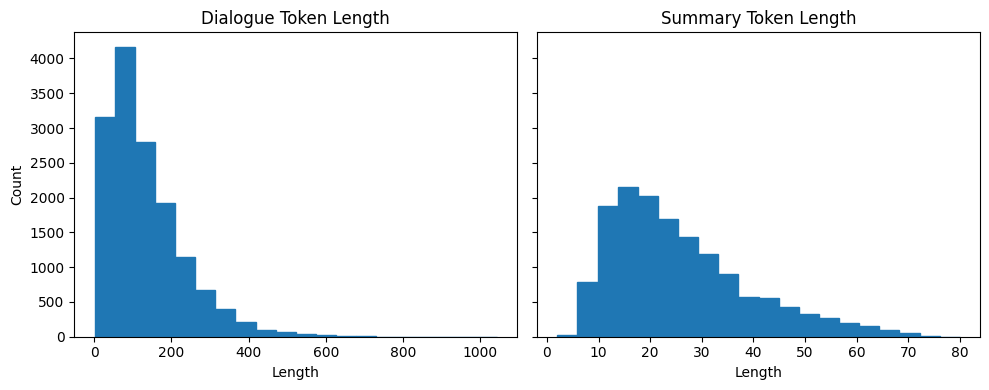

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True )
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

In [ ]:

from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)


In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install transformers[torch] --upgrade


In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=2, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

In [ ]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()

score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )